In [1]:
import os
import random
import time
import json
import shutil
import sys
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
sys.path.append('/opt/ml/input/baseline/utils')
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

#!pip install webcolors
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


In [2]:
%matplotlib inline

dataset_path  = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

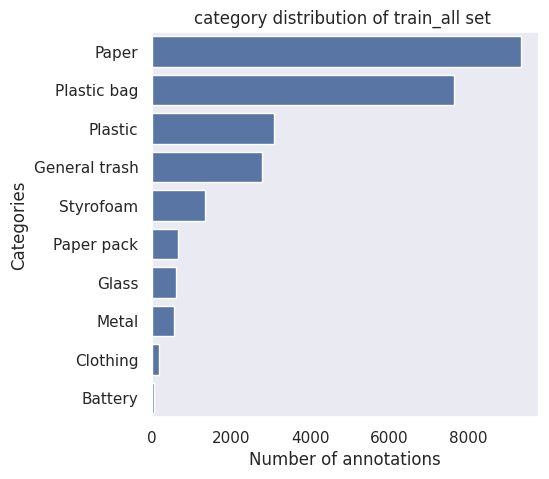

In [3]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [4]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

## 데이터 전처리 함수 정의 (Dataset)

In [5]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=self.ids[index])
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [6]:
# train.json / validation.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 1  

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.92s)
creating index...
index created!
loading annotations into memory...
Done (t=1.14s)
creating index...
index created!


## Mask image 생성

In [7]:
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    file_dir = f"/opt/ml/input/data/annotations/train/{image_infos['id']:04}.png"

    masks = masks[0].numpy()
    
    cv2.imwrite(file_dir, masks)

for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    file_dir = f"/opt/ml/input/data/annotations/val/{image_infos['id']:04}.png"

    masks = masks[0].numpy()
    
    cv2.imwrite(file_dir, masks)

## Image Directory 변경

In [11]:
root = "/opt/ml/input/data/"
train_ann = os.path.join(root, "train.json")
val_ann = os.path.join(root, "val.json")
test_ann = os.path.join(root, "test.json")
 
def cp_img(json_dir, img_path):
    img_path = "/opt/ml/input/data/" + img_path
    os.makedirs(img_path, exist_ok=True)
    with open(json_dir, "r", encoding="utf8") as outfile:
        anno = json.load(outfile)
    imgs = anno["images"]

    for img in imgs:
        shutil.copyfile(
            os.path.join("/opt/ml/input/data", img["file_name"]),
            os.path.join(img_path, f"{img['id']:04}.jpg"),
        )

In [12]:
cp_img(train_ann, "images/train")
cp_img(val_ann, "images/val")
cp_img(test_ann, "test")

In [ ]:
root = "/opt/ml/input/data/"
train_ann = os.path.join(root, "train.json")
val_ann = os.path.join(root, "val.json")
test_ann = os.path.join(root, "test.json")
def cp_img(json_dir, img_path):
    image_path = "/opt/ml/input/data/" + img_path
    os.makedirs(image_path, exist_ok=True)
    with open(json_dir, "r", encoding="utf8") as outfile:
        anno = json.load(outfile)
    imgs = anno["images"]
    for img in imgs:
        shutil.copyfile(
            os.path.join("/opt/ml/input/data", img["file_name"]),
            os.path.join(image_path, f"{img['id']:04}.jpg"),
        )